In [165]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
# Shuffle the dataset
from sklearn.utils import shuffle


In [166]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()



In [167]:
# Flatten if needed (depends on model)
# x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0

# Select majority classes (0–4)
x_majority = x_train[y_train < 5]
y_majority = y_train[y_train < 5]

# Select minority classes (5–9), only 4000 samples
x_minority = x_train[y_train >= 5][:3000]
y_minority = y_train[y_train >= 5][:3000]

# Combine the two
x_train_imbalanced = np.concatenate([x_majority, x_minority], axis=0)
y_train_imbalanced = np.concatenate([y_majority, y_minority], axis=0)


x_train_imbalanced, y_train_imbalanced = shuffle(x_train_imbalanced, y_train_imbalanced, random_state=42)


# One-hot encode labels
y_train_cat = to_categorical(y_train_imbalanced, 10)
y_test_cat = to_categorical(y_test, 10)



[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842  525  622  669  565  619]


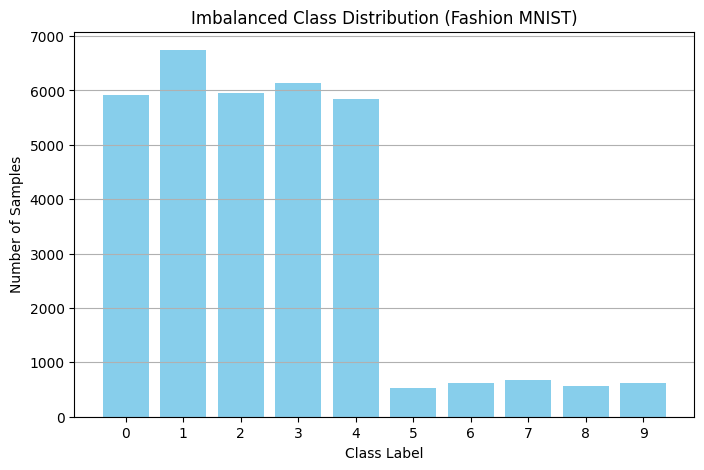

In [168]:
# Plot the bar chart
classes, counts = np.unique(y_train_imbalanced, return_counts=True)
print(classes, counts)
plt.figure(figsize=(8, 5))
plt.bar(classes, counts, tick_label=[str(c) for c in classes], color='skyblue')
plt.title("Imbalanced Class Distribution (Fashion MNIST)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.show()

In [169]:
# Focal Loss implementation
def focal_loss(gamma=2.0, alpha=0.1):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

# Model architecture
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model



In [170]:
# Model with Focal Loss
model_focal = create_model()
model_focal.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
history_focal = model_focal.fit(x_train_imbalanced, y_train_cat, epochs=20, batch_size=128, validation_split=0.2, verbose=1)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5754 - loss: 0.8583 - val_accuracy: 0.6930 - val_loss: 0.6294
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7057 - loss: 0.6026 - val_accuracy: 0.7223 - val_loss: 0.5708
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7185 - loss: 0.5766 - val_accuracy: 0.7411 - val_loss: 0.5333
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7381 - loss: 0.5369 - val_accuracy: 0.7461 - val_loss: 0.5212
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7480 - loss: 0.5185 - val_accuracy: 0.7443 - val_loss: 0.5244
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7482 - loss: 0.5174 - val_accuracy: 0.7539 - val_loss: 0.5062
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7510 - loss: 0.5129 - val_accuracy: 0.7579 - val_loss: 0.4994
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7572 - loss: 0.5001 - val_accuracy: 0.7515 - val

In [171]:
# Evaluate
loss_focal, acc_focal = model_focal.evaluate(x_test, y_test_cat, verbose=1)

# Show results
print(f"Focal Loss              - Accuracy: {acc_focal:.4f}, Loss: {loss_focal:.4f}")

# Predict on test set
y_pred_focal = model_focal.predict(x_test)

# Convert predictions to class labels
y_pred_focal_cls = np.argmax(y_pred_focal, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("Focal Loss Report:\n", classification_report(y_true, y_pred_focal_cls))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7886 - loss: 0.4301
Focal Loss              - Accuracy: 0.8072, Loss: 0.3921
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Focal Loss Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       980
           1       0.96      0.99      0.98      1135
           2       0.89      0.97      0.93      1032
           3       0.71      0.97      0.82      1010
           4       0.48      0.99      0.65       982
           5       0.93      0.65      0.76       892
           6       0.95      0.89      0.92       958
           7       0.94      0.86      0.90      1028
           8       0.90      0.74      0.81       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.81     10000
   macro avg       0.77      0.80      0.77     10000
weighted avg       0.77      0.81      0.77     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
